# Pneumonia Detection

## Importing Packages

In [73]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [ ]:
pip install split-folders

## Building File structure

In [ ]:
input_folder = 'C:/Users/Sibi/Downloads/proj_data'
splitfolders.ratio(input_folder,output = "proj_data2", seed  = 42, ratio = (0.7,0.2,0.1), group_prefix = None)

## Dataset Generation

In [2]:
TARGET_SIZE = 224

train_datagen = ImageDataGenerator(rescale=1./255.,
                                     featurewise_center=True,
                                       zoom_range = 0.07,
                                     validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale= 1./255)

train_data = train_datagen.flow_from_directory(
    'C:/Users/Sibi/Downloads/proj_data2/train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE,TARGET_SIZE),
    shuffle=True,
    subset="training",
)

validation_data = train_datagen.flow_from_directory(
    'C:/Users/Sibi/Downloads/proj_data2/train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=True,
    subset="validation",
)

test_data = test_datagen.flow_from_directory(
    'C:/Users/Sibi/Downloads/proj_data2/test',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False,
)

Found 1924 images belonging to 2 classes.
Found 213 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


## Building model from Resnet152

In [3]:
base_model = tf.keras.applications.ResNet152V2(weights="imagenet",include_top= False,input_shape=(TARGET_SIZE,TARGET_SIZE, 3))

for layer in base_model.layers[:300]:
    layer.trainable = False

for layer in base_model.layers[300:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

predictions = Dense(1, activation='sigmoid')(x)



model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
model.summary()
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

## Model Training

In [6]:
EPOCHS = 10
history = model.fit_generator(
     train_data,
     steps_per_epoch=train_data.samples//train_data.batch_size,
     epochs = EPOCHS,
     validation_data = validation_data,
     validation_steps=validation_data.samples//validation_data.batch_size,
     callbacks = [model_save])

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8652 
Epoch 00001: val_loss improved from inf to 2079914496.00000, saving model to weights.h5
60/60 [==============================] - 930s 16s/step - loss: 0.3328 - accuracy: 0.8652 - val_loss: 2079914496.0000 - val_accuracy: 0.5000
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9588 
Epoch 00002: val_loss improved from 2079914496.00000 to 33.66858, saving model to weights.h5
60/60 [==============================] - 925s 15s/step - loss: 0.1493 - accuracy: 0.9588 - val_loss: 33.6686 - val_accuracy: 0.5990
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9683 
Epoch 00003: val_loss improved from 33.66858 to 0.08447, saving model to weights.h5
60/60 [==============================] - 956s 16s/step - loss: 0.1140 - accuracy: 0.9683 - val_loss: 0.0845 - val_accuracy: 0.9844
Epoch 4/10
60/60 [=============================

## Evaluation

In [84]:

pred = model.predict_generator(test_data)
for i,_ in enumerate(pred):
        #print(i)
        if(pred[i] > 0.05):
            y_pred[i] = 1
        else:
            y_pred[i] = 0
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1]


In [49]:
model.evaluate(test_data)


9/9 [==============================] - 38s 4s/step - loss: 0.2301 - accuracy: 0.9308


[0.23009255528450012, 0.9307692050933838]

In [50]:
model.save('resnet101.h5')

## Visualizing Predictions

Pneumonia Detected


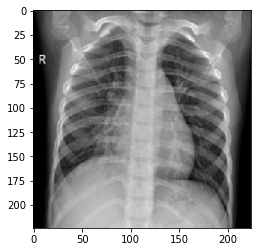

In [86]:
img_path ="C:/Users/Sibi/Downloads/proj_data2/test/ViralPneumonia/Viral Pneumonia-141.png"
img = load_img(img_path, target_size=(224, 224))
inputdata = img_to_array(img)
inputdata = np.expand_dims(inputdata, axis=0)
inputdata =  preprocess_input(inputdata)
imgplot = plt.imshow(img)
(preds) = model.predict(inputdata)
if (preds < 0.05):
    print("Normal")
else:
    print("Pneumonia Detected")

Normal


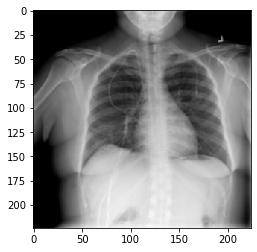

In [87]:
img_path ="C:/Users/Sibi/Downloads/proj_data2/test/Normal/Normal-6100.png"
img = load_img(img_path, target_size=(224, 224))
inputdata = img_to_array(img)
inputdata = np.expand_dims(inputdata, axis=0)
inputdata =  preprocess_input(inputdata)
imgplot = plt.imshow(img)
(preds) = model.predict(inputdata)
if (preds < 0.05):
    print("Normal")
else:
    print("Pneumonia Detected")

## Plotting Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


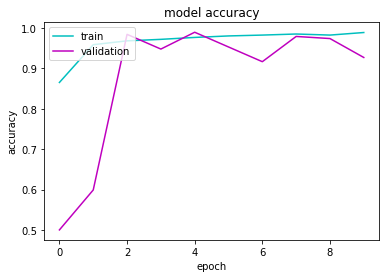

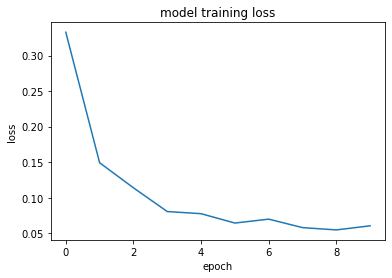

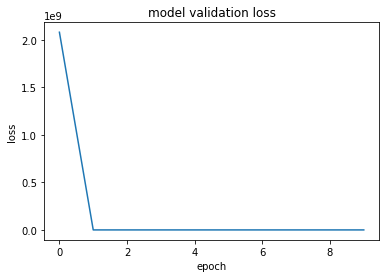

In [51]:
print(history.history.keys())
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Performance Metrics

Confusion Matrix
[[125   0]
 [  9 126]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.93284   1.00000   0.96525       125
           1    1.00000   0.93333   0.96552       135

    accuracy                        0.96538       260
   macro avg    0.96642   0.96667   0.96538       260
weighted avg    0.96771   0.96538   0.96539       260



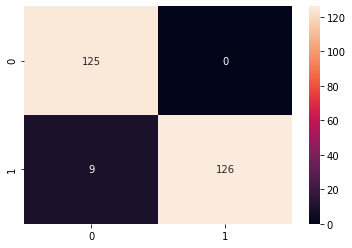

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)
print(sns.heatmap(confusion_matrix(test_data.classes, y_pred),annot=True,fmt="d"))
print(classification_report(test_data.classes, y_pred, digits=5))


In [53]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(np.mean(recall))
print(np.mean(precision))

0.9666666666666667
0.9664179104477613
